# Working with Multispectral Data

# Table of Contents

- [Introduction](#Introduction)
- [Prerequisites](#Prerequisites)
- [Imports](#Imports)
- [Data preparation](#Data-preparation)
- [Visualise Training data](#Visualise-Training-data)
    - [Different Band Combination](#Different-Band-Combination)
- [Train Model](#Train-Model)
    - [Model Initialization options](#Model-Initialization-options)
    - [Learning Rate](#Learning-Rate)
- [Validate results](#Validate-results)
- [Inferencing](#Inferencing)

# Introduction

We can use multispectral imagery with any `arcgis.learn` model. A few additional parameters can be used when we are training on multispectral imagery which are discussed in this guide.

# Prerequisites

- To work with multispectral data **gdal** needs to be installed in addtion to fastai and pytorch, please refer to the section "Install deep learning dependencies of arcgis.learn module" on this page [Install deep learning dependencies of arcgis.learn module](https://developers.arcgis.com/python/guide/install-and-set-up/) for detailed documentation on installation of these dependencies.


# Imports


In [1]:
import arcgis
from arcgis.learn import prepare_data, UnetClassifier

# Data preparation

While working with multispectral data we can use the following keyword arguments in addition to the standard parameters for the `prepare_data()` function. It is required to specify either of the keyword arguments `imagery_type`, `bands`, `rgb_bands` to work with multispectral data.

- `imagery_type`: The type of imagery used to export the training data. We can use any of the well know imagery types:
    - 'sentinel2'
    - 'naip'
    - 'landsat8'
    - 'ms' - any other type of imagery
    
  If the imagery used to export the training data is not one of the well know types you can specify 'ms' against `imagery_type`. In that case we need to either specify `rgb_bands` or `bands` parameter to preserve weights for the RGB bands otherwise all the bands would be considered unknown.      
    
    
- `bands`: If training data is not exported using one of the well known imagery type, we can specify the bands contained in our imagery. For example ['r', 'g', 'b', 'nir', 'u'] here 'nir' is and 'u' is a miscellaneous band.


- `rgb_bands`: We can specify the indices of red, green, blue bands in the imagery or None if that band does not exist in the imagery. This is further used as the default band combination for visualization using the `{data}.show_batch()` and `{model}.show_results()` methods, this is an optional parameter. For example [2, 1, 0] or [2, 1, None].

    
- `extract_bands`: By default the model gets trainined on all bands available in the imagery of our training data. We can use this parameter to filter the bands on which we want to train our model on. For example '[4, 2, 1, 0]' if we do not want to train on the band at 3 index of the imagery.

    
- `norm_pct`: The percentage of training data used to calculate imagery statistics which is further used to normalize the data while training the model. It is an optional parameter and by default it is set to 0.3 or 30% of data.

In [2]:
data = prepare_data(
    r'C:\Workspace\Data\LULC\traindata_sentinel2_ms_400px', 
    batch_size=4,    
    imagery_type='sentinel2',
    norm_pct=1
)

## Visualise Training data

we can use the `{data}.show_batch()` method to visualize a few samples of the training data. Following parameters can be used with multispectral imagery to control the visualization.

- `rgb_bands`: The band combination in which we want to visualize our training data, For example [2, 1, 0] or ['nir', 'g', 'b'].  

- `statistics_type`: The type of stretching we want to apply to imagery in our training data for visualization.
    - 'DRA': Stretch each image chip by using its min-max values.

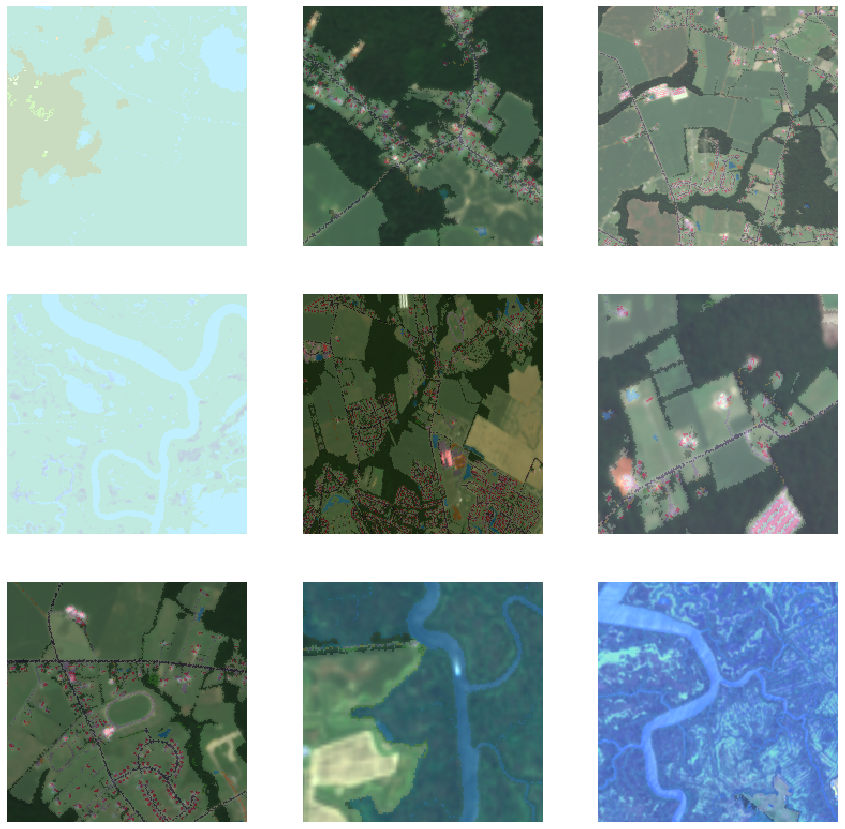

In [3]:
data.show_batch(statistics_type='DRA', alpha=0.5)

### Different Band Combination

**False Color Composite**  
red -> nir  
green -> green  
blue -> blue  

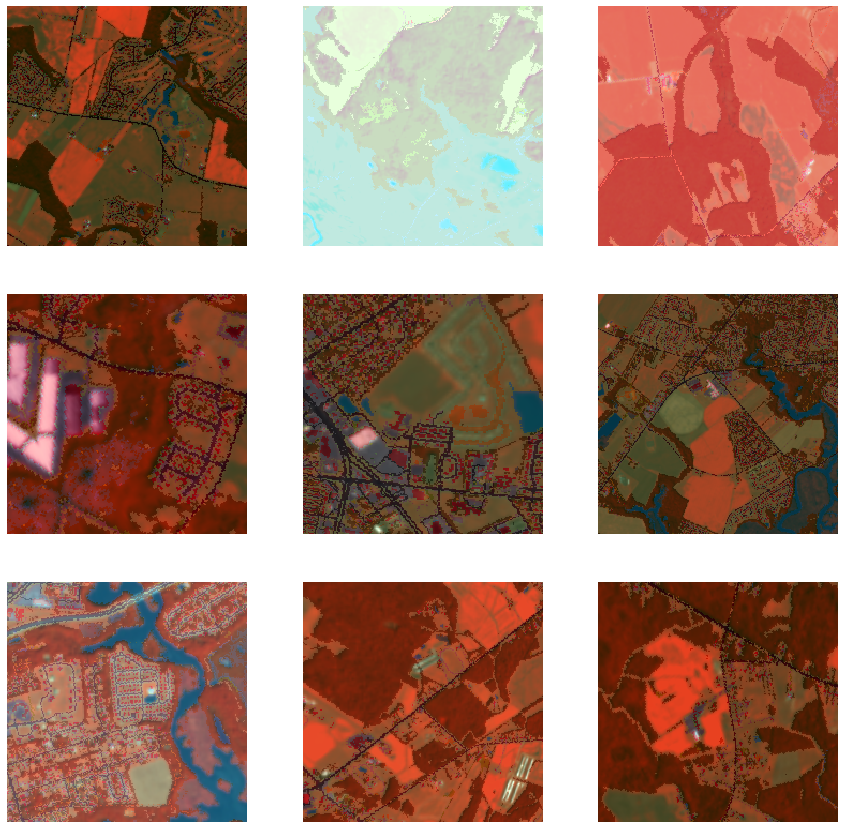

In [4]:
data.show_batch(rgb_bands=[7, 2, 1], statistics_type='DRA', alpha=0.5)

## Train Model

### Model Initialization options

`arcgis.learn` uses transfer learning to enhance the model training experience. To train these models with multispectral data the model needs to accomodate the various types of bands available in multispectral imageries. 

This is done by reinitializing the first layer of the model, an arcgis environment variable `arcgis.env.type_init_tail_parameters` can be used to specify the scheme in which the weights are intialized for the layer.  Valid weight initialization schemes are:

- 'random' - default : Random weights are initialized for Non-RGB bands while preserving pretrained weights for RGB bands.
- 'red_band': Weights corresponding to the Red band from the pretrained model's layer are cloned for Non-RGB bands while preserving pretrained weights for RGB bands.
- 'all_random': Random weights are initialized for RGB bands as well as Non-RGB bands.



In [5]:
#arcgis.env.type_init_tail_parameters = 'random'

In [6]:
# Create the model
model = UnetClassifier(data)

### Learning Rate

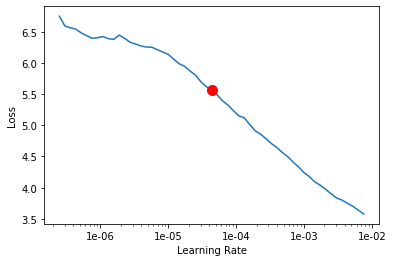

4.365158322401661e-05

In [7]:
# Find a learning rate
model.lr_find()

We can use the `{data}.lr_find()` method to find an appropriate learning rate. Because the first layer of the model has been reinitalized it is trainable and has to be trained at a lower learning rate then the remaining trainable part of the model. To do that we can use the `slice(low_lr:high_lr)` notation, specifying a lower learning rate for the first layer and a higher learning rate for the remaining trainable part of the model. 

Because the first layer in our model has been just initialized we might need to train the model a bit longer to get the best results.

In [43]:
model.fit(30, lr=slice(0.00001, 0.0001), checkpoint=False)

epoch,train_loss,valid_loss,accuracy,time
0,2.250466,1.494668,0.572943,00:16
1,2.005482,1.261981,0.548816,00:06
2,1.822036,1.336223,0.582071,00:07
3,1.713578,1.102631,0.634762,00:06
4,1.595475,1.020310,0.605489,00:07
5,1.499705,0.964417,0.649287,00:07
6,1.428693,0.939621,0.624713,00:07
7,1.377642,0.913481,0.744535,00:07
8,1.316385,0.843814,0.763708,00:07
9,1.269287,0.859898,0.730580,00:07


KeyboardInterrupt: 

## Validate results

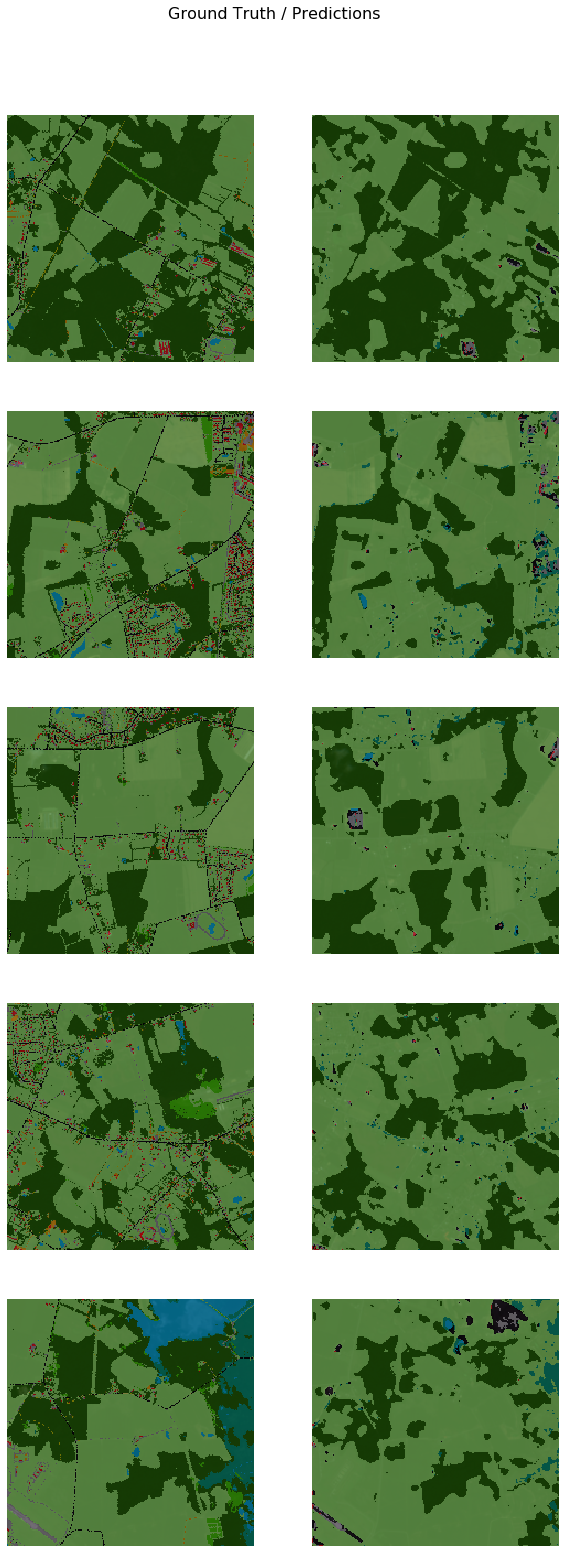

In [44]:
model.show_results()

## Inferencing

We can save the model using the `{model}.save()` method, output of this method is a saved model file in dlpk format. The model can be then deployed using ArcGIS Pro or ArcGIS Image Server. Depending on the type of model which we train, some of the tools that work with these deep learning models are:

- [Classify Pixels Using Deep Learning](#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm)  
- [Detect Objects Using Deep Learning](#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/detect-objects-using-deep-learning.htm)  
- [Classify Objects Using Deep Learning](#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-objects-using-deep-learning.htm)  

In this example example we have tried to train a `UnetClassifier` which is a pixel classification model, so the tool [Classify Pixels Using Deep Learning](#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) would work with our saved model.

In [9]:
model.save('10e')

WindowsPath('C:/Workspace/Data/LULC/traindata_sentinel2_ms_400px/models/10e')